## 자료분석특론2 HW5
### 212STG10 박영은

### 전처리

In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
cancer = pd.read_csv('breast-cancer.data', header=None)
cancer_columns = open('breast-cancer.names', 'r')
cancer_columns = pd.DataFrame(cancer_columns,columns=['names'])

In [3]:
cancer_columns = cancer_columns.iloc[52:64].reset_index().drop(columns='index')

In [4]:
cancer.columns = ['Class', 'age', 'menopause', 'tumor_size', 'inv_nodes', 'node_caps', 'deg_malig', 'breast', 'breast_quad', 'irradiat']
cancer = cancer.astype('str')

In [5]:
# 결측치 확인
cancer.isnull().sum()

Class          0
age            0
menopause      0
tumor_size     0
inv_nodes      0
node_caps      0
deg_malig      0
breast         0
breast_quad    0
irradiat       0
dtype: int64

In [6]:
# 무응답 삭제
cancer=cancer[cancer['breast_quad']!='?']
cancer=cancer[cancer['node_caps']!='?']

In [7]:
# 변수 더미화
cancer_new = pd.get_dummies(data = cancer)
cancer_new = cancer_new.iloc[:,1:]

In [8]:
# 칼럼명 변경
cancer_new.columns = ['Class_recurrence_events', 'age_20', 'age_30', 'age_40',
       'age_50', 'age_60', 'age_70', 'menopause_ge40',
       'menopause_lt40', 'menopause_premeno', 'tumor_size_0',
       'tumor_size_10', 'tumor_size_15', 'tumor_size_20',
       'tumor_size_25', 'tumor_size_30', 'tumor_size_35',
       'tumor_size_40', 'tumor_size_45', 'tumor_size_5',
       'tumor_size_50', 'inv_nodes_0', 'inv_nodes_12',
       'inv_nodes_15', 'inv_nodes_24', 'inv_nodes_3', 'inv_nodes_6',
       'inv_nodes_9', 'node_caps_no', 'node_caps_yes',
       'deg_malig_1', 'deg_malig_2', 'deg_malig_3', 'breast_left',
       'breast_right', 'breast_quad_central',
       'breast_quad_left_low', 'breast_quad_left_up', 'breast_quad_right_low',
       'breast_quad_right_up', 'irradiat_no', 'irradiat_yes']

In [10]:
cancer_new.shape

(277, 42)

### train, test 분리

In [11]:
y = cancer_new['Class_recurrence_events']
X = cancer_new.drop('Class_recurrence_events',axis=1, inplace=False)

# training set 80%, test set 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)

train = pd.concat([X_train, y_train], axis=1)

### 1. Logistic Regression

#### GLM 사용

In [12]:
formula = 'Class_recurrence_events ~ age_20 + age_30 + age_40 + age_50 + age_60 + age_70 + \
menopause_ge40  +  menopause_lt40 + menopause_premeno + \
tumor_size_0 + tumor_size_10 + tumor_size_15 + tumor_size_20 + tumor_size_25 + tumor_size_30 +\
tumor_size_35 + tumor_size_40 + tumor_size_45 + tumor_size_5 + tumor_size_50  + \
inv_nodes_0 + inv_nodes_12 + inv_nodes_15 + inv_nodes_24  + inv_nodes_3 + inv_nodes_6 + inv_nodes_9 + \
node_caps_no + node_caps_yes + \
deg_malig_1 + deg_malig_2 + deg_malig_3 + breast_left + breast_right + \
breast_quad_central + breast_quad_left_low + breast_quad_left_up + breast_quad_right_low + breast_quad_right_up + \
irradiat_no + irradiat_yes'

In [13]:
# train set으로 학습, test set으로 예측
model = smf.glm(formula=formula, data = train, family=sm.families.Binomial())
result = model.fit()
print(result.summary())
pred_y = result.predict(X_test)
print(pred_y[0:10].values)

                    Generalized Linear Model Regression Results                    
Dep. Variable:     Class_recurrence_events   No. Observations:                  221
Model:                                 GLM   Df Residuals:                      188
Model Family:                     Binomial   Df Model:                           32
Link Function:                       logit   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                    nan
Date:                     Thu, 14 Oct 2021   Deviance:                          nan
Time:                             23:08:33   Pearson chi2:                 2.84e+17
No. Iterations:                        100                                         
Covariance Type:                 nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

In [14]:
# predict된 값 중 1의 확률
predictions_nominal = ["0" if x < 0.5 else "1" for x in pred_y]
list(predictions_nominal).count('1')/len(predictions_nominal)

0.2857142857142857

각 observation의 확률 중 앞 10개는 [0. 0. 1. 0. 1. 0. 0. 0. 0. 1.] 이고,

총 predict된 값을 0.5를 기준으로 0과 1로 분류하였을 때 1의 확률은 약 0.29이다.

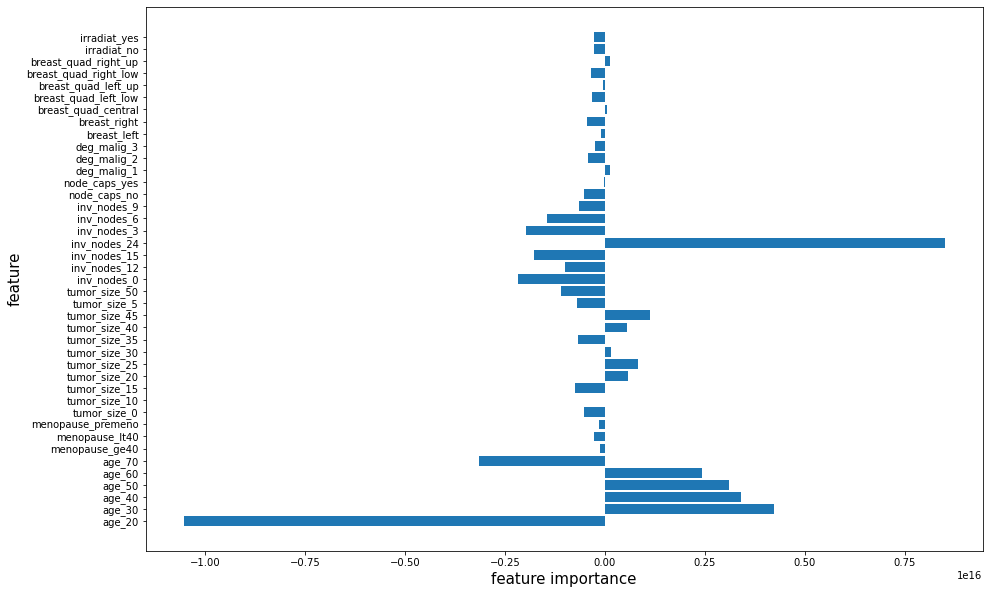

In [15]:
# 변수 중요도
feature_imp = result.params.values[1:]

n_feature = train.iloc[:,:41].shape[1]
idx = np.arange(n_feature)

plt.figure(figsize=(15,10))
plt.barh(idx, feature_imp, align='center')
plt.yticks(idx, train.iloc[:,:41].columns)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()

전체 변수가 모델에 영향을 미쳤으며 각 변수의 중요도는 위와 같고, 그 중 age_20이 변수 중요도가 가장 높다(음의 방향으로 영향을 미침). p-value를 확인한 결과 모든 변수가 유의하다.

In [16]:
# 전체 data로 학습 및 예측
model = smf.glm(formula=formula, data = cancer_new, family=sm.families.Binomial())
result = model.fit()
print(result.summary())
pred_y = result.predict()
print(pred_y[0:10])

                    Generalized Linear Model Regression Results                    
Dep. Variable:     Class_recurrence_events   No. Observations:                  277
Model:                                 GLM   Df Residuals:                      244
Model Family:                     Binomial   Df Model:                           32
Link Function:                       logit   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                    nan
Date:                     Thu, 14 Oct 2021   Deviance:                          nan
Time:                             23:08:34   Pearson chi2:                 3.51e+17
No. Iterations:                        100                                         
Covariance Type:                 nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

In [17]:
# predict된 값 중 1의 확률
predictions_nominal = ["0" if x < 0.5 else "1" for x in pred_y]
list(predictions_nominal).count('1')/len(predictions_nominal)

0.2815884476534296

각 observation의 확률 중 앞 10개는 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 이고,

총 predict된 값을 0.5를 기준으로 0과 1로 분류하였을 때 1의 확률은 약 0.28이다.

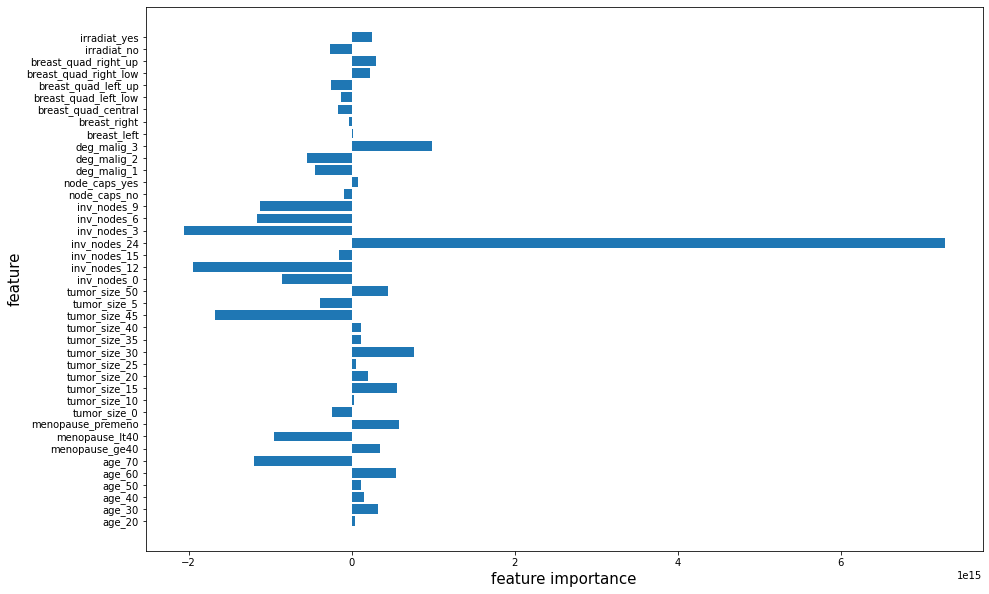

In [18]:
# 변수 중요도
feature_imp = result.params.values[1:]

n_feature = X.shape[1]
idx = np.arange(n_feature)

plt.figure(figsize=(15,10))
plt.barh(idx, feature_imp, align='center')
plt.yticks(idx, X.columns)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()

전체 변수가 모델에 영향을 미쳤으며 각 변수의 중요도는 위와 같고, 그 중 inv_nodes_24가 변수 중요도가 가장 높다. p-value를 확인한 결과 모든 변수가 유의하다. 

#### LogisticRegression 사용

In [19]:
# train set으로 학습, test set으로 예측
lg_clf = LogisticRegression(random_state=2021)
lg_clf.fit(X_train, y_train)
pred_y = lg_clf.predict(X_test)
print(lg_clf.predict_proba(X_test)[0:10])

[[0.94037849 0.05962151]
 [0.89508635 0.10491365]
 [0.62872984 0.37127016]
 [0.92773171 0.07226829]
 [0.56056181 0.43943819]
 [0.50147    0.49853   ]
 [0.93652657 0.06347343]
 [0.80991637 0.19008363]
 [0.56329007 0.43670993]
 [0.54480665 0.45519335]]


In [20]:
# predict된 값 중 1의 확률
list(pred_y).count(1)/len(pred_y)

0.23214285714285715

각 observation에 대해 1로 예측될 확률 중 앞 10개는 [0.06, 0.10, 0.37, 0.07, 0.44, 0.50, 0.06, 0.19, 0.44, 0.46] 이고,

총 predict된 값을 0.5를 기준으로 0과 1로 분류하였을 때 1의 확률은 약 0.23이다.

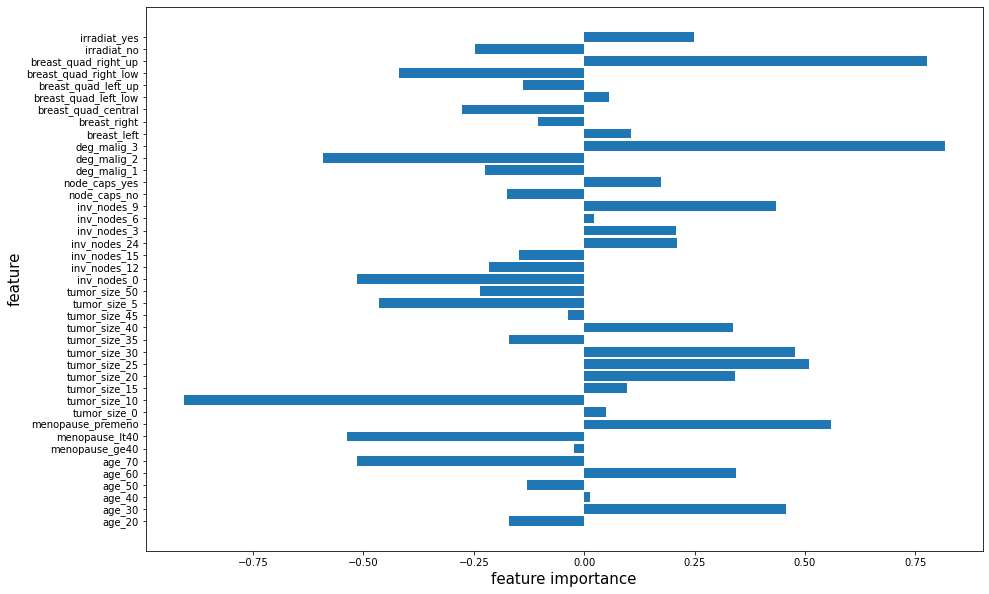

In [21]:
# 변수 중요도
feature_imp = lg_clf.coef_[0]

n_feature = train.iloc[:,:41].shape[1]
idx = np.arange(n_feature)

plt.figure(figsize=(15,10))
plt.barh(idx, feature_imp, align='center')
plt.yticks(idx, train.iloc[:,:41].columns)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()

전체 변수가 모델에 영향을 미쳤으며 각 변수의 중요도는 위와 같고, 그 중 tumor_size_10이 변수 중요도가 가장 높다(다만, 음의 방향으로 영향을 미침).

In [22]:
# 전체 data로 학습 및 예측
lg_clf = LogisticRegression(random_state=2021)
lg_clf.fit(X, y)
pred_y = lg_clf.predict(X)
print(lg_clf.predict_proba(X_test)[0:10])

[[0.93280338 0.06719662]
 [0.7385672  0.2614328 ]
 [0.77207358 0.22792642]
 [0.9410499  0.0589501 ]
 [0.51850513 0.48149487]
 [0.67958301 0.32041699]
 [0.95486726 0.04513274]
 [0.82681317 0.17318683]
 [0.57493754 0.42506246]
 [0.67220507 0.32779493]]


In [23]:
# predict된 값 중 1의 확률
list(pred_y).count(1)/len(pred_y)

0.22021660649819494

각 observation에 대해 1로 예측될 확률 중 앞 10개는 [0.07, 0.26, 0.23, 0.06, 0.48, 0.32, 0.05, 0.17, 0.43, 0.33] 이고,

총 predict된 값을 0.5를 기준으로 0과 1로 분류하였을 때 1의 확률은 약 0.22이다.

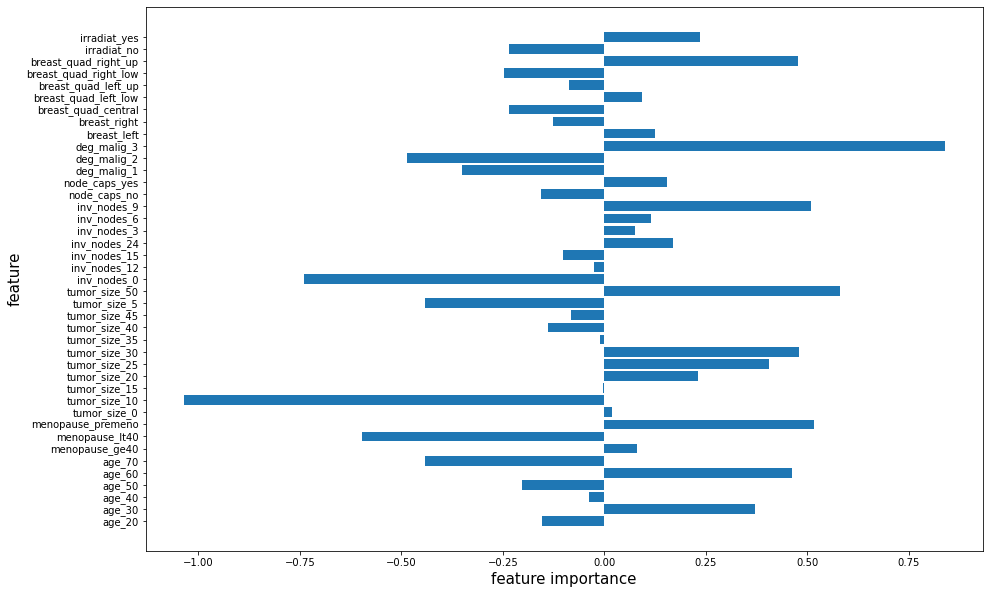

In [24]:
# 변수 중요도
feature_imp = lg_clf.coef_[0]

n_feature = X.shape[1]
idx = np.arange(n_feature)

plt.figure(figsize=(15,10))
plt.barh(idx, feature_imp, align='center')
plt.yticks(idx, X.columns)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()

전체 변수가 모델에 영향을 미쳤으며 각 변수의 중요도는 위와 같고, 그 중 tumor_size_10이 변수 중요도가 가장 높다(음의 방향으로 영향을 미침). 

### 2. Regression Tree

In [25]:
# train set으로 학습, test set으로 예측
tree_clf = DecisionTreeRegressor(max_depth=5, random_state=42)
tree_clf.fit(X_train, y_train)
pred_y = tree_clf.predict(X_test)
print(pred_y[0:10])

[0.14814815 0.14814815 0.31818182 0.14814815 0.70588235 0.
 0.         0.31818182 0.14814815 0.31818182]


In [26]:
# predict된 값 중 1의 확률
predictions_nominal = ["0" if x < 0.5 else "1" for x in pred_y]
list(predictions_nominal).count('1')/len(predictions_nominal)

0.16071428571428573

각 observation에 대해 1로 예측될 확률 중 앞 10개는 [0.14814815, 0.14814815, 0.31818182, 0.14814815, 0.70588235, 0., 0., 0.31818182, 0.14814815, 0.31818182] 이고,

총 predict된 값을 0.5를 기준으로 0과 1로 분류하였을 때 1의 확률은 약 0.23이다.

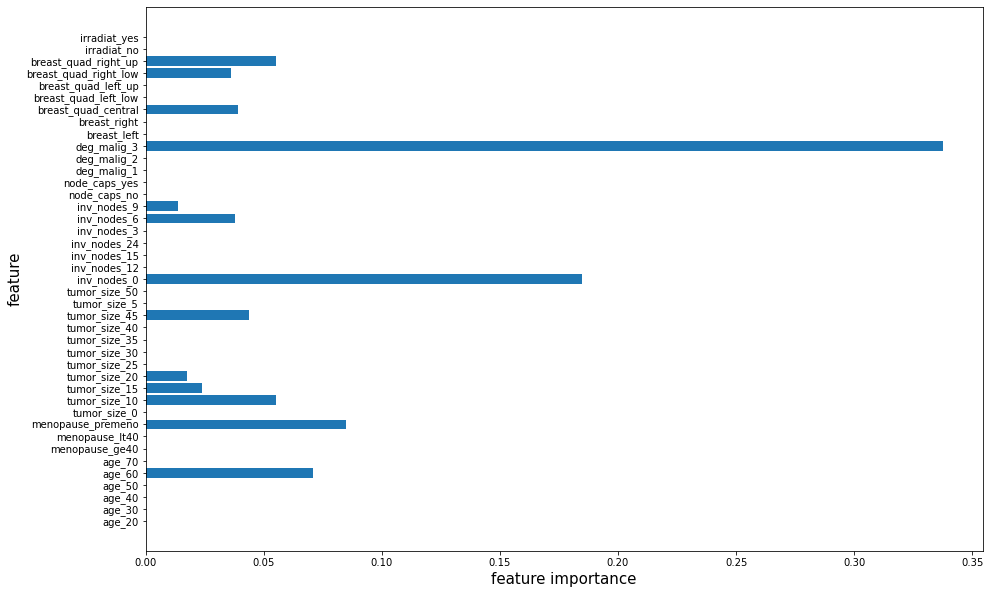

In [27]:
# 변수 중요도
feature_imp = tree_clf.feature_importances_

n_feature = train.iloc[:,:41].shape[1]
idx = np.arange(n_feature)

plt.figure(figsize=(15,10))
plt.barh(idx, feature_imp, align='center')
plt.yticks(idx, train.iloc[:,:41].columns)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()

breast_quad_right_up, breast_quad_right_low, breast_quad_central, deg_malig_3, inv_nodes_9, inv_nodes_6, inv_nodes_0, tumor_size_45, tumor_size_20, tumor_size_15, tumor_size_10, menopause_ge40, age_60 이 모델에 사용된 변수이다. 그 중 deg_malig_3 변수가 가장 영향력이 높다

In [28]:
# 전체 data로 학습 및 예측
tree_clf = DecisionTreeRegressor(max_depth=5, random_state=42)
tree_clf.fit(X, y)
pred_y = tree_clf.predict(X)
print(pred_y[0:10])

[0.55555556 0.16935484 0.16935484 0.16935484 0.16935484 0.16935484
 0.16935484 0.16935484 0.16935484 0.16935484]


In [29]:
predictions_nominal = ["0" if x < 0.5 else "1" for x in pred_y]
list(predictions_nominal).count('1')/len(predictions_nominal)

0.23104693140794225

각 observation에 대해 1로 예측될 확률 중 앞 10개는 [0.55555556, 0.16935484, 0.16935484, 0.16935484, 0.16935484, 0.16935484,
 0.16935484, 0.16935484, 0.16935484, 0.16935484] 이고,

총 predict된 값을 0.5를 기준으로 0과 1로 분류하였을 때 1의 확률은 약 0.23이다.

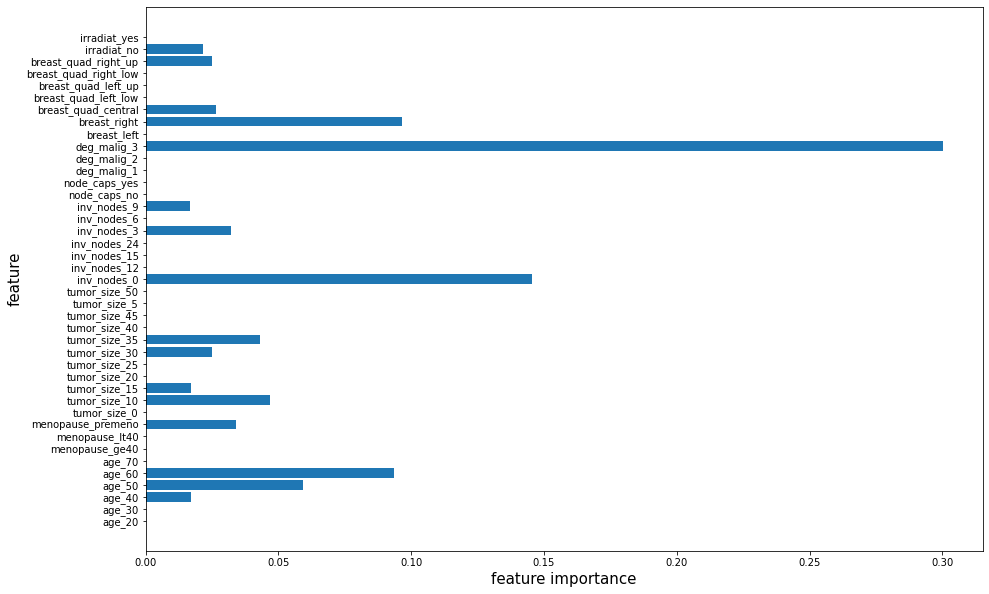

In [30]:
# 변수 중요도
feature_imp = tree_clf.feature_importances_

n_feature = X.shape[1]
idx = np.arange(n_feature)

plt.figure(figsize=(15,10))
plt.barh(idx, feature_imp, align='center')
plt.yticks(idx, X.columns)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()

breast_quad_right_no, breast_quad_right_up, breast_quad_central, breast_right, deg_malig_3, inv_nodes_9, inv_nodes_3, inv_nodes_0, tumor_size_35, tumor_size_30, tumor_size_15, tumor_size_10, menopause_premeno, age_60, age_50, age_40 이 모델에 사용된 변수이다. 그 중 deg_malig_3 변수가 가장 영향력이 높다

### 3. 결과 비교

#### Logistic Regression
- GLM을 사용한 경우: recurrence event가 예측될 확률은 28~29%였다.
- sklearn의 LogisticRegression을 사용한 경우:recurrence event가 예측될 확률은 22~23%였다.

#### Regression Tree
- sklearn의 DecisionTreeRegressor을 사용한 경우: recurrence event가 예측될 확률은 23%였다.

두 경우 모두 비슷한 확률로 recurrence event가 예측되었다. 하지만, Logistic regression은 모든 변수를 사용한 반면, Regression tree는 특정 변수만 사용하였기 때문에 보다 단순한 모델인 regression tree가 더 좋은 모델이 될 수 있다. 하지만 Regression tree 역시 과적합 가능성이 큰 모델이라는 점을 유의해야한다.